# Demo notebook: Tiled GEDI dataset on the MAAP

## 1. Database layout and simple access

This notebook demonstrates the capabilities of the tiled GEDI dataset: a (moderately) filtered copy of the GEDI data that is spatiotemporally sorted into tiles covering 1º x 1º x 1 year.

We will be working with a demo version of the database hosted at: 
`s3://maap-ops-workspace/shared/ameliah/gedi-test/brazil_tiles/data`

This database was constructed to the following specification:
- All GEDI footprints from 2019 - 2023 (first phase of the GEDI mission)
- Version 2.1
- Products L2A, L2B, L4A, and L4C, joined on shot_number
- Footprints are pre-filtered for:
    - Level 2A quality_flag == 1 (** n.b. this is not the same as the L4A flag "l2a_quality_flag")
    - 0.9 <= sensitivity_a0 <= 1
    - 0.95 < sensitivity_a2 <= 1
    - degrade_flag %in% [0, 3, 8, 10, 13, 18, 20, 23, 28, 30, 33, 38, 40, 43, 48, 60, 63, 68]
    - surface_flag == 1
- If a footprint is not present in all four products, it will not be present in the database.

The demo database covers Brazil and is divided into 818 1ºx1º tiles as shown below:

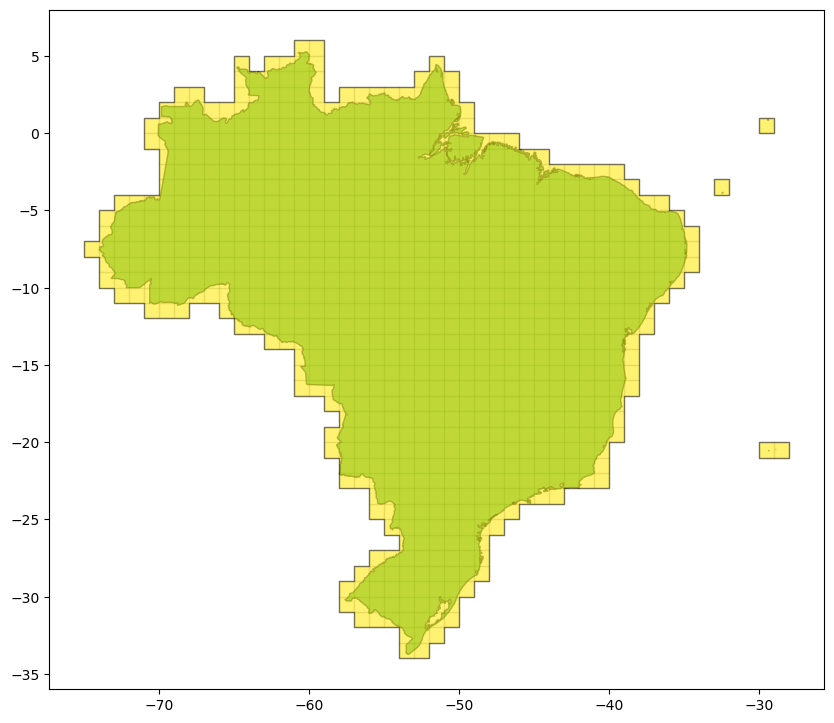

Tiles are named in the format `[NS][##]_[EW][###]`, specifying the top left corner of the tile.

Thus, S21_W049 covers latitudes in the range [-21, -22) and longitudes in the range [-49, -48).


### TL;DR: I just want to read one tile

In [1]:
tile_id = "S21_W049" # your tile_id goes here

from gtiler.database import ducky
con = ducky.init_duckdb()
ddf = con.sql(f"SELECT * FROM read_parquet('{ducky.brazil_data_spec()}') WHERE tile_id = '{tile_id}'")
gdf = ducky.duck_to_gdf(ddf)

gdf # a geopandas dataframe with all the data for this tile

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,shot_number,elev_lowestmode,delta_time,sensitivity,sensitivity_a1,sensitivity_a2,degrade_flag,quality_flag,landsat_treecover,modis_treecover,modis_treecover_sd,modis_nonvegetated,modis_nonvegetated_sd,solar_elevation,solar_azimuth,...,wsci,wsci_pi_lower,wsci_pi_upper,wsci_quality_flag,wsci_xy,wsci_xy_pi_lower,wsci_xy_pi_upper,wsci_z,wsci_z_pi_lower,wsci_z_pi_upper,granule,absolute_time,geometry,tile_id,year
0,27890800100094155,467.034363,4.540009e+07,0.970950,0.970950,0.987709,0,1,0.0,8.0,5.19,14.0,5.19,14.986346,57.285740,...,6.968864,4.357741,9.579988,0,4.520601,2.532623,6.508580,3.743029,2.282539,5.203518,O02789_01,2019-06-10 04:08:12.766828-07:00,POINT (-48.92974 -21.47246),S21_W049,2019
1,27890800100094156,465.252686,4.540009e+07,0.971777,0.971777,0.989145,0,1,0.0,8.0,5.19,14.0,5.19,14.986862,57.285637,...,7.382654,4.771531,9.993778,0,5.137434,3.149456,7.125412,3.794650,2.334161,5.255140,O02789_01,2019-06-10 04:08:12.775092-07:00,POINT (-48.92939 -21.47206),S21_W049,2019
2,27890800100094157,463.657654,4.540009e+07,0.968382,0.968382,0.985826,0,1,31.0,7.0,6.71,17.0,6.71,14.987378,57.285538,...,7.279002,4.667878,9.890125,0,4.956734,2.968755,6.944712,3.757522,2.297033,5.218012,O02789_01,2019-06-10 04:08:12.783356-07:00,POINT (-48.92905 -21.47166),S21_W049,2019
3,27890800100094158,461.497375,4.540009e+07,0.973064,0.973064,0.989640,0,1,37.0,7.0,6.71,17.0,6.71,14.987894,57.285435,...,7.292437,4.681313,9.903561,1,4.962675,2.974697,6.950654,3.784134,2.323644,5.244623,O02789_01,2019-06-10 04:08:12.791620-07:00,POINT (-48.9287 -21.47126),S21_W049,2019
4,27890800100094159,459.628174,4.540009e+07,0.974676,0.974676,0.989871,0,1,37.0,7.0,7.21,16.0,7.21,14.988411,57.285332,...,7.501962,4.890838,10.113085,1,5.150930,3.162951,7.138908,3.811793,2.351303,5.272283,O02789_01,2019-06-10 04:08:12.799884-07:00,POINT (-48.92835 -21.47086),S21_W049,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099471,206591100400329973,613.712646,1.449844e+08,0.964020,0.964020,0.984009,0,1,0.0,13.0,3.06,17.0,3.06,-62.745358,-95.861694,...,7.000647,4.389523,9.611771,0,4.436053,2.448074,6.424031,3.749616,2.289126,5.210105,O20659_04,2022-08-05 18:26:36.866268-07:00,POINT (-48.24056 -21.78913),S21_W049,2022
1099472,206591100400329974,611.717590,1.449844e+08,0.952309,0.952309,0.978804,0,1,0.0,17.0,9.25,20.0,9.25,-62.745670,-95.862679,...,7.270982,4.659859,9.882106,0,4.727520,2.739542,6.715499,3.826697,2.366207,5.287187,O20659_04,2022-08-05 18:26:36.874532-07:00,POINT (-48.24022 -21.78953),S21_W049,2022
1099473,206591100400329975,611.323303,1.449844e+08,0.965441,0.965441,0.988480,0,1,0.0,16.0,9.07,20.0,9.07,-62.745987,-95.863686,...,9.372114,8.097961,10.646267,1,5.571395,4.628877,6.513914,5.332156,4.429989,6.234323,O20659_04,2022-08-05 18:26:36.882796-07:00,POINT (-48.23987 -21.78992),S21_W049,2022
1099474,206591100400329976,610.002930,1.449844e+08,0.965496,0.965496,0.984665,0,1,0.0,16.0,9.07,20.0,9.07,-62.746300,-95.864670,...,9.926510,9.042625,10.810394,1,5.779849,5.221303,6.338395,5.695436,5.028692,6.362179,O20659_04,2022-08-05 18:26:36.891060-07:00,POINT (-48.23952 -21.79032),S21_W049,2022


#### Cool! Tell me more ...
The above code made use of a framework called DuckDB, along with a small helper library (`gtiler.database.ducky`). 
While you can sidestep this framework and read the individual per-tile data files directly out of S3 with pandas/geopandas/R dataframes if you are so inclined, these tools are not designed with large datasets in mind and will be relatively slow.

The Tiled GEDI dataset is laid out in a format such that many distributed frameworks will be able to help you quickly scan and query the data. These tools, which include DuckDB, Spark, Dask, and others, are designed to help you run your usual dataframe code over datasets that are too large to fit in memory. You can use these tools alone or in combination with geopandas/R dataframes -- for example, selecting a subset of the data from the database with a fast query framework and then converting it to your standard library for further processing.

Below is an introduction to using [DuckDB](https://duckdb.org) to work with the GEDI data.

## 2. Introduction to DuckDB and SQL

DuckDB is a query engine that supports efficient querying of large datasets split among many files.
It queries using SQL, a standard language for interacting with tabular data. 
The DuckDB SQL API docs are [here](https://duckdb.org/docs/stable/sql/introduction),
and generally most internet advice for SQL (especially the dialect called "PostgreSQL") will also work in DuckDB.

DuckDB also can be used in R with the package `duckplyr`. All the SQL commands shown below will be the same in R, 
but instead of `con.sql("SQL COMMAND")` you will run `dbGetQuery(con, "SQL COMMAND")`.
For more details, see the R client API docs [here](https://duckdb.org/docs/stable/clients/r.html).

We start out by creating a duckDB connection and getting the location of the demo database.

I suggest restarting your Jupyter notebook Kernel at this point to clean up the memory used by the tile loaded in Part 1, then you are ready to run the cell below:

In [1]:
# A convenience library that sets up DuckDB with appropriate configuration
# for the Tiled GEDI database.
from gtiler.database import ducky
con = ducky.init_duckdb()

# data_spec is simply a string that we use to tell duckDB the location of the data files
data_spec = ducky.brazil_data_spec()
print(data_spec)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

s3://maap-ops-workspace/shared/ameliah/gedi-test/brazil_tiles/data/*/*/*.parquet


### SQL: SELECT and FROM

In [2]:
# The simplest SQL query has two clauses: SELECT and FROM
# SELECT specifies which columns to return
# FROM specifies which table to query

# Try modifying the list of columns below to see what else is available in the database.
# Try a mistyped column name (like "SELECT rh_098 FROM ...") to see how DuckDB reports errors.

con.sql(f"""--sql
    SELECT shot_number, agbd, rh_98, l4_quality_flag, geometry
    FROM read_parquet('{data_spec}')
""")

┌───────────────────┬───────────┬───────┬─────────────────┬────────────────────────────────────────────────┐
│    shot_number    │   agbd    │ rh_98 │ l4_quality_flag │                    geometry                    │
│      uint64       │   float   │ float │      uint8      │                    geometry                    │
├───────────────────┼───────────┼───────┼─────────────────┼────────────────────────────────────────────────┤
│ 33771100400270971 │       0.0 │  2.51 │               1 │ POINT (-46.9946661103302 -0.97584802727075)    │
│ 33771100400270972 │       0.0 │  2.43 │               1 │ POINT (-46.99436888763849 -0.976269963621268)  │
│ 33771100400270973 │       0.0 │  2.39 │               1 │ POINT (-46.99407165518076 -0.976691896036926)  │
│ 33771100400270974 │       0.0 │  2.47 │               1 │ POINT (-46.993774420470956 -0.977113822443567) │
│ 33771100400270975 │       0.0 │  2.36 │               1 │ POINT (-46.99347716587506 -0.977535748549778)  │
│ 33771100400270976

A few things to notice about the above query:
- It's very fast (~2 seconds). No individual tile was fully loaded into memory to produce the output
- It's not showing all the data, just a preview of 20 rows
- We used the special function `read_parquet` to read all the parquet files matching `data_spec` into one DuckDB table
- The database includes a `geometry` column, which contains a spatial datatype. This is `POINT(lon_lowestmode, lat_lowestmode)`

You can select all columns using '*'
For example, below we select all columns from the database, and then use the `.columns` function to get the complete list of columns in the database.

In [ ]:
con.sql(f"""--sql SELECT * FROM read_parquet('{data_spec}')""").columns

['shot_number',
 'elev_lowestmode',
 'delta_time',
 'sensitivity',
 'sensitivity_a1',
 'sensitivity_a2',
 'degrade_flag',
 'quality_flag',
 'landsat_treecover',
 'modis_treecover',
 'modis_treecover_sd',
 'modis_nonvegetated',
 'modis_nonvegetated_sd',
 'solar_elevation',
 'solar_azimuth',
 'energy_total',
 'digital_elevation_model',
 'digital_elevation_model_srtm',
 'num_detectedmodes',
 'rh_0',
 'rh_1',
 'rh_2',
 'rh_3',
 'rh_4',
 'rh_5',
 'rh_6',
 'rh_7',
 'rh_8',
 'rh_9',
 'rh_10',
 'rh_11',
 'rh_12',
 'rh_13',
 'rh_14',
 'rh_15',
 'rh_16',
 'rh_17',
 'rh_18',
 'rh_19',
 'rh_20',
 'rh_21',
 'rh_22',
 'rh_23',
 'rh_24',
 'rh_25',
 'rh_26',
 'rh_27',
 'rh_28',
 'rh_29',
 'rh_30',
 'rh_31',
 'rh_32',
 'rh_33',
 'rh_34',
 'rh_35',
 'rh_36',
 'rh_37',
 'rh_38',
 'rh_39',
 'rh_40',
 'rh_41',
 'rh_42',
 'rh_43',
 'rh_44',
 'rh_45',
 'rh_46',
 'rh_47',
 'rh_48',
 'rh_49',
 'rh_50',
 'rh_51',
 'rh_52',
 'rh_53',
 'rh_54',
 'rh_55',
 'rh_56',
 'rh_57',
 'rh_58',
 'rh_59',
 'rh_60',
 'rh_61',

### SQL: WHERE

In [6]:
# We can now add a third SQL clause: WHERE
# WHERE specifies a filter condition that rows must meet to be included in the output

# Feel free to modify the filter condition below and test the changes to the output
# For example, try a filter that compares two different columns.
# Add those columns to the SELECT statement (don't forget commas!) to preview the data
# and check that your filter is working as you expect

con.sql(f"""--sql
    SELECT shot_number, agbd, rh_98, l4_quality_flag, geometry
    FROM read_parquet('{data_spec}')
    WHERE l4_quality_flag = 1 AND agbd > 25
""")

┌────────────────────┬────────────┬───────┬─────────────────┬────────────────────────────────────────────────┐
│    shot_number     │    agbd    │ rh_98 │ l4_quality_flag │                    geometry                    │
│       uint64       │   float    │ float │      uint8      │                    geometry                    │
├────────────────────┼────────────┼───────┼─────────────────┼────────────────────────────────────────────────┤
│ 206431100400267047 │  32.967716 │ 14.08 │               1 │ POINT (-46.71190660039602 -0.987512177710429)  │
│ 206431100400267048 │  45.361107 │ 16.73 │               1 │ POINT (-46.71160807671686 -0.987934735142634)  │
│ 206431100400267049 │  67.302986 │ 19.76 │               1 │ POINT (-46.711310565117934 -0.988356101676648) │
│ 206431100400267057 │   109.9276 │ 20.28 │               1 │ POINT (-46.70893902335896 -0.99172033640705)   │
│ 206431100400267058 │   97.81765 │ 10.01 │               1 │ POINT (-46.708637516448086 -0.992147684200313) │
│

In [ ]:
# The query can also include computed columns
# See https://duckdb.org/docs/stable/sql/functions/
# It is also possible to write your own functions in Python and register them with DuckDB,
# though you will find that many useful functions are already built-in.

# Here, we compute the average AGBD and RH 98 for high-quality shots in a specific tile.

con.sql(f"""--sql
    SELECT AVG(agbd), AVG(rh_98)
    FROM read_parquet('{data_spec}')
    WHERE l4_quality_flag = 1 AND tile_id = 'S21_W049'
""")


┌────────────────────┬───────────────────┐
│     avg(agbd)      │    avg(rh_98)     │
│       double       │      double       │
├────────────────────┼───────────────────┤
│ 11.193237748166522 │ 5.338944693551338 │
└────────────────────┴───────────────────┘

In [ ]:
# Before we go further, a quick note on formatting.
# The following is a correct SQL statement that does the same thing as the previous code cell:
print(con.sql(f"select avg(agbd), avg(rh_98) from read_parquet('{data_spec}') where l4_quality_flag = 1 and tile_id = 'S21_W049'"))

# But it is harder to read, especially as queries get more complex.
# So I recommend formatting SQL code like this:

# 1. Use tabs and newlines:
# SQL ignores tabs and newlines, so you can use them to format your code for readability.
# A common convention is to put each clause (SELECT, FROM, WHERE, etc.) on its own line,
# and, if you have a lot of columns or conditions, to indent the contents of each clause by one tab.
# Use triple quotes (""") for a multi-line string in Python.

# 2. Use comments to indicate SQL code:
# -- is a comment in SQL.
# Putting --sql at the start of the string is not required (and ignored by DuckDB), 
# but it allows some editors (like VSCode with the "inline SQL" extension) to
# provide SQL syntax highlighting inside the string.

# 3. Capitalize SQL keywords:
# We usually use capital letters for SQL keywords (SELECT, FROM, WHERE, etc.)
# and lower-case letters for column names (shot_number, agbd, rh_98, etc.)
# This is not required, but it helps to visually distinguish keywords from column names.

# For example, this is a nicely formatted query:
con.sql(f"""--sql
    SELECT
        AVG(agbd), 
        AVG(rh_98), 
        COUNT(shot_number), 
        MIN(agbd), 
        MAX(agbd)
    FROM 
        read_parquet('{data_spec}')
    WHERE 
        tile_id = 'S21_W049'
        AND l4_quality_flag = 1 
        AND rh_98 > 20
        AND solar_elevation > 30
""")


┌────────────────────┬───────────────────┐
│     avg(agbd)      │    avg(rh_98)     │
│       double       │      double       │
├────────────────────┼───────────────────┤
│ 12.232413338670172 │ 5.294282060142416 │
└────────────────────┴───────────────────┘



┌───────────────────┬────────────────────┬────────────────────┬───────────┬───────────┐
│     avg(agbd)     │     avg(rh_98)     │ count(shot_number) │ min(agbd) │ max(agbd) │
│      double       │       double       │       int64        │   float   │   float   │
├───────────────────┼────────────────────┼────────────────────┼───────────┼───────────┤
│ 158.6428000518198 │ 25.353516540861143 │               3657 │ 28.202814 │ 1822.4059 │
└───────────────────┴────────────────────┴────────────────────┴───────────┴───────────┘

#### Spatial querying

This is a spatial database, so we can also run spatial queries on the data.
A list of spatial functions supported by DuckDB can be found [here](https://duckdb.org/docs/stable/core_extensions/spatial/functions.html). 

The explanation of these spatial functions in the docs is pretty sparse, but they work
the same as in PostGIS, so you can consult [the PostGIS documentation](https://postgis.net/docs/manual-3.6/reference.html) to understand what each function does (with pictures!)


Note that not all PostGIS functions are implemented in DuckDB.

Probably the most useful function is `ST_Contains()`, which you can use to query the GEDI footprints for an AOI.

In [9]:
# Start by creating an example shapefile for an AOI that crosses four tiles.
# We are making a simple bounding box, but you can use any shapefile here.
import geopandas as gpd
from shapely.geometry import box

region_gdf = gpd.GeoDataFrame(geometry=[box(-63.2, -4.2, -62.8, -3.8)], crs="EPSG:4326")
region_gdf.to_file("/projects/my-public-bucket/shapefiles/test_region.shp")

In [10]:
# Read the shapefile into DuckDB
# `SELECT *` reads all columns
# `ST_Read` is a special function to read shapefiles (similar to read_parquet, which we use for the GEDI data)
region_df = con.sql("SELECT * FROM ST_Read('/projects/my-public-bucket/shapefiles/test_region.shp')")
region_df

┌───────┬────────────────────────────────────────────────────────────────────────┐
│  FID  │                                  geom                                  │
│ int64 │                                geometry                                │
├───────┼────────────────────────────────────────────────────────────────────────┤
│     0 │ POLYGON ((-62.8 -4.2, -63.2 -4.2, -63.2 -3.8, -62.8 -3.8, -62.8 -4.2)) │
└───────┴────────────────────────────────────────────────────────────────────────┘

In [11]:
# Now we'll compute the average AGBD and RH 98 for high-quality shots within the AOI

# We can speed up spatial queries considerably with a tile filter clause.
# See "Query speed and optimization" below for the explanation, but for now --
# Use `ducky.spatial_filter_clause(shp)` to get a SQL clause telling DuckDB 
# which tiles to search in. This speeds up the query from minutes to seconds.
fast_filter = ducky.spatial_filter_clause(region_gdf)
print(fast_filter)
# Now we run the spatial query
con.sql(f"""--sql
        SELECT 
            AVG(agbd), 
            AVG(rh_98), 
            COUNT(shot_number)
        FROM 
            read_parquet('{data_spec}') AS d,
            region_df AS r
        WHERE 
            ST_Contains(r.geom, d.geometry) 
            AND l4_quality_flag = 1 
            AND ({fast_filter})
        """)

# REMINDER: If your shapefile is in a different CRS, be sure to reproject the GEDI geometry column to match,
# e.g. ST_Contains(r.geom, ST_Transform(d.geometry, 'EPSG:4326', 'your-crs-here'))

(tile_id = 'S03_W064' OR tile_id = 'S04_W064' OR tile_id = 'S03_W063' OR tile_id = 'S04_W063')


┌────────────────────┬───────────────────┬────────────────────┐
│     avg(agbd)      │    avg(rh_98)     │ count(shot_number) │
│       double       │      double       │       int64        │
├────────────────────┼───────────────────┼────────────────────┤
│ 125.54187008430279 │ 20.80863550482044 │              53236 │
└────────────────────┴───────────────────┴────────────────────┘

A few tricks to notice in the query above:
- In the FROM clause, we added another table: region_df
- We used `ducky.spatial_filter_clause` as a fast filter to help DuckDB quickly identify the relevant files. See "Query speed and optimization", below, for details.
- We used "AS" to rename our variables. This lets us easily reference them again elsewhere in the query by a short variable name
- In the "WHERE" clause, we now specify which table the column comes from using "." For example, d.geometry references the geometry column in the table named "d". We could also include this in the rest of the query (e.g. `d.agbd, d.rh_98, d.shot_number`, etc.), but the table name can be omitted if there are no columns with the same name in multiple tables.

### SQL: GROUP BY

The final type of SQL clause we will introduce in this demo is GROUP BY.
This is used to aggregate data based on a single key and compute a summary.

For example, let's say we were running an analysis on phenology with GEDI,
and we wanted to understand how biomass and PAI varied from month to month in our region.

We want the mean biomass and pai _grouped by_ the month in which the GEDI shot was collected.

In [ ]:
# absolute_time is a timestamp column giving the date and time of each shot
# MONTH is a built-in function that works on timestamps
# A more general-use function is DATE_PART, e.g. DATE_PART('month', absolute_time) 
# which can be used to extract the month, year, day, hour, etc.
# See https://duckdb.org/docs/stable/sql/functions/datetime

con.sql(f"""--sql
        SELECT
            AVG(agbd),
            AVG(pai),
        FROM 
            read_parquet('{data_spec}') AS d, 
            region_df AS r
        WHERE 
            l4_quality_flag = 1 
            AND ST_Contains(r.geom, d.geometry) 
            AND ({fast_filter})
        GROUP BY 
            MONTH(absolute_time)
        """)

┌────────────────────┬────────────────────┐
│     avg(agbd)      │      avg(pai)      │
│       double       │       double       │
├────────────────────┼────────────────────┤
│  86.21296011897896 │ 2.3934141616446887 │
│ 113.42279633753517 │  2.754164984760619 │
│  96.86361327499682 │  2.574946743907004 │
│ 166.54189448218418 │ 3.6789607549931165 │
│ 126.30922107474062 │ 2.8232617386878447 │
│   91.1950243222979 │  2.411827307974821 │
│   120.741287507591 │ 2.8538512254157813 │
│ 132.23756975663218 │ 2.9901523928873384 │
│ 119.47871183088803 │ 3.0687753763540226 │
│ 181.68983351665995 │ 3.6196915896042534 │
│ 142.17775347862334 │ 3.2759549969039625 │
├────────────────────┴────────────────────┤
│ 11 rows                       2 columns │
└─────────────────────────────────────────┘

Hmm, to make that a little clearer, let's add a column showing which month each 
row corresponds to, sorting the months in order.

We'll use "AS" to make this easier to read.

In [13]:
con.sql(f"""--sql
        SELECT
            MONTH(absolute_time) AS month_num,
            AVG(agbd),
            AVG(pai),
            COUNT(shot_number) AS num_shots
        FROM 
            read_parquet('{data_spec}') AS d, 
            region_df AS r
        WHERE 
            l4_quality_flag = 1 
            AND ST_Contains(r.geom, d.geometry) 
            AND ({fast_filter})
        GROUP BY month_num
        ORDER BY month_num
        """)

┌───────────┬────────────────────┬────────────────────┬───────────┐
│ month_num │     avg(agbd)      │      avg(pai)      │ num_shots │
│   int64   │       double       │       double       │   int64   │
├───────────┼────────────────────┼────────────────────┼───────────┤
│         1 │   91.1950243222979 │  2.411827307974821 │      5427 │
│         2 │  86.21296011897896 │ 2.3934141616446887 │      1123 │
│         3 │ 181.68983351665995 │ 3.6196915896042534 │        23 │
│         4 │ 132.23756975663218 │ 2.9901523928873384 │     17144 │
│         5 │  96.86361327499682 │  2.574946743907004 │      2829 │
│         6 │ 119.47871183088803 │ 3.0687753763540226 │      2260 │
│         7 │ 126.30922107474062 │ 2.8232617386878447 │      5238 │
│         8 │   120.741287507591 │ 2.8538512254157813 │      4328 │
│         9 │ 113.42279633753517 │  2.754164984760619 │      3935 │
│        10 │ 142.17775347862334 │ 3.2759549969039625 │      7155 │
│        12 │ 166.54189448218418 │ 3.67896075499

Now, let's say I'm worried there's a problem with this analysis -- the data probably came from 
different years for each month. Let's add a column listing the years that we have data for each month.

In [14]:
# We use ARRAY_AGG to aggregate values into a list
# and DISTINCT will give us only the unique values.
con.sql(f"""--sql
        SELECT
            MONTH(absolute_time) AS month_num,
            AVG(agbd),
            AVG(pai),
            ARRAY_AGG(DISTINCT YEAR(absolute_time)) AS years,
            COUNT(shot_number) AS num_shots,
        FROM 
            read_parquet('{data_spec}') AS d, 
            region_df AS r
        WHERE 
            l4_quality_flag = 1 
            AND ST_Contains(r.geom, d.geometry) 
            AND ({fast_filter})
        GROUP BY month_num
        ORDER BY month_num
        """)

┌───────────┬────────────────────┬────────────────────┬──────────────────────────┬───────────┐
│ month_num │     avg(agbd)      │      avg(pai)      │          years           │ num_shots │
│   int64   │       double       │       double       │         int64[]          │   int64   │
├───────────┼────────────────────┼────────────────────┼──────────────────────────┼───────────┤
│         1 │   91.1950243222979 │  2.411827307974821 │ [2020, 2022, 2021]       │      5427 │
│         2 │  86.21296011897896 │ 2.3934141616446887 │ [2023, 2021]             │      1123 │
│         3 │ 181.68983351665995 │ 3.6196915896042534 │ [2022]                   │        23 │
│         4 │ 132.23756975663218 │ 2.9901523928873384 │ [2022, 2020, 2021]       │     17144 │
│         5 │  96.86361327499682 │  2.574946743907004 │ [2022, 2019]             │      2829 │
│         6 │ 119.47871183088803 │ 3.0687753763540226 │ [2021, 2019, 2020]       │      2260 │
│         7 │ 126.30922107474062 │ 2.8232617386878

#### SQL: DESCRIBE

One useful feature is the ability to inspect the structure of the database itself.
What columns are available? What datatypes are stored in them?

To figure this out, we can use the DESCRIBE statement.

In [ ]:
con.sql(f"""--sql DESCRIBE SELECT * FROM read_parquet('{data_spec}')""")
# There's a lot of extra information here -- focus on column_name and column_type


┌───────────────────┬──────────────────────────┬─────────┬─────────┬─────────┬─────────┐
│    column_name    │       column_type        │  null   │   key   │ default │  extra  │
│      varchar      │         varchar          │ varchar │ varchar │ varchar │ varchar │
├───────────────────┼──────────────────────────┼─────────┼─────────┼─────────┼─────────┤
│ shot_number       │ UBIGINT                  │ YES     │ NULL    │ NULL    │ NULL    │
│ elev_lowestmode   │ FLOAT                    │ YES     │ NULL    │ NULL    │ NULL    │
│ delta_time        │ DOUBLE                   │ YES     │ NULL    │ NULL    │ NULL    │
│ sensitivity       │ FLOAT                    │ YES     │ NULL    │ NULL    │ NULL    │
│ sensitivity_a1    │ FLOAT                    │ YES     │ NULL    │ NULL    │ NULL    │
│ sensitivity_a2    │ FLOAT                    │ YES     │ NULL    │ NULL    │ NULL    │
│ degrade_flag      │ UTINYINT                 │ YES     │ NULL    │ NULL    │ NULL    │
│ quality_flag      │

Hmm, that's helpful, but still too many columns to print all of them. Can we search them easily? Of course! Using a SQL WHERE clause.

This one will search for strings that contain a substring -- so if, for example, you want all the columns with elevation-related data, you can search for column names that contain the substring `elev` 

In [ ]:
describe_df = con.sql(f"""--sql DESCRIBE SELECT * FROM read_parquet('{data_spec}')""")

# Try putting other strings in between the percent signs to find other columns
# For example, search for all the 'flag' columns
con.sql("""--sql
        SELECT column_name, column_type 
        FROM describe_df 
        WHERE column_name LIKE '%elev%'
    """)

┌──────────────────────────────┬─────────────┐
│         column_name          │ column_type │
│           varchar            │   varchar   │
├──────────────────────────────┼─────────────┤
│ elev_lowestmode              │ FLOAT       │
│ solar_elevation              │ FLOAT       │
│ digital_elevation_model      │ FLOAT       │
│ digital_elevation_model_srtm │ FLOAT       │
│ elev_highestreturn_a1        │ FLOAT       │
│ elev_highestreturn_a2        │ FLOAT       │
└──────────────────────────────┴─────────────┘

SQL has _lots_ more functionality, but hopefully this gives a sense of how DuckDB allows us to perform useful queries on the GEDI data and compute or preview the results within seconds.

### Converting back to pandas/geopandas

If at any point you are struggling to use DuckDB to do what you want, it's easy to convert back to pandas/geopandas.

Here is an example of the code to select a list of columns of interest from one of the tiles, matching a simple filter, and convert the data to pandas.

In [ ]:
pdf = con.sql(f"""--sql
    SELECT 
        shot_number, 
        agbd, 
        pai_z_0, 
        pai_z_1, 
        dz, 
        lat_lowestmode, 
        lon_lowestmode, 
        geometry
    FROM read_parquet('{data_spec}')
    WHERE 
        tile_id = 'S11_W058' 
        AND l4_quality_flag = 1 
        AND l2b_quality_flag = 1
""").to_df()  # call .to_df() on any DuckDB table to convert it to Pandas.

# For most column types, this is a no-copy operation, so it should be about as fast as reading with pandas.
# In this case, it is much faster than reading the raw data files with pandas, 
# because DuckDB automatically parallelizes the read, loading all five subfiles (each containing 1 year of GEDI data) simultaneously

# Show the output
pdf

,shot_number,agbd,pai_z_0,pai_z_1,dz,lat_lowestmode,lon_lowestmode,geometry
0,23241100400304830,16.777878,0.206776,0.166779,5.0,-11.927471,-57.172293,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
1,23241100400304831,65.334419,2.291555,1.691760,5.0,-11.927887,-57.171981,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
2,23241100400304833,207.414703,2.977851,2.498830,5.0,-11.928719,-57.171356,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
3,23241100400304834,150.035675,4.430523,3.634233,5.0,-11.929135,-57.171043,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
4,23241100400304835,173.110474,5.571114,4.836654,5.0,-11.929551,-57.170731,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
...,...,...,...,...,...,...,...,...
537907,103340300400257821,184.960815,4.288225,3.703870,5.0,-11.096011,-57.850339,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
537908,103340300400257822,47.407887,2.867896,2.169436,5.0,-11.096427,-57.850032,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
537909,103340300400257823,64.662788,3.178881,2.104782,5.0,-11.096844,-57.849722,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
537910,103340300400257824,174.186768,2.908264,2.242050,5.0,-11.097261,-57.849413,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."


There is one wrinkle, though: take a look at the `geometry` column in the pandas dataframe above.
DuckDB and pandas don't use an interoperable geometry format, and it gets garbled in conversion.

If you don't care about the geometry column and are happy using `lat_lowestmode` and `lon_lowestmode`, don't worry about this.

If you want a geopandas dataframe, though, use the ducky library function to help with this conversion:

In [ ]:
ddf = con.sql(f"""--sql
    SELECT 
        shot_number, 
        agbd,
        pai_z_0, 
        pai_z_1, 
        dz, 
        lat_lowestmode, 
        lon_lowestmode, 
        geometry
    FROM read_parquet('{data_spec}')
    WHERE 
        tile_id = 'S11_W058' 
        AND l4_quality_flag = 1 
        AND l2b_quality_flag = 1
""")
# convert a DuckDB table to a geopandas dataframe.
# Specify the name of the geometry column in the `geometry_column` argument
# By default, the function assumes the geometry_column is called "geometry"
gdf = ducky.duck_to_gdf(ddf)

gdf

,shot_number,agbd,pai_z_0,pai_z_1,dz,lat_lowestmode,lon_lowestmode,geometry
0,205980500400367167,14.711697,0.597110,0.492436,5.0,-11.706626,-57.346001,POINT (-57.346 -11.70663)
1,205980500400367168,2.373579,0.296114,0.149011,5.0,-11.707044,-57.345689,POINT (-57.34569 -11.70704)
2,205980500400367169,7.336771,0.537859,0.294743,5.0,-11.707463,-57.345377,POINT (-57.34538 -11.70746)
3,205980500400367170,7.797517,1.157384,0.607831,5.0,-11.707878,-57.345066,POINT (-57.34507 -11.70788)
4,205980500400367171,0.000000,0.142268,0.003221,5.0,-11.708294,-57.344755,POINT (-57.34475 -11.70829)
...,...,...,...,...,...,...,...,...
537907,201250600400807744,0.000000,0.072495,-0.000000,5.0,-11.936821,-57.560680,POINT (-57.56068 -11.93682)
537908,201250600400807745,0.000000,0.068643,-0.000000,5.0,-11.937238,-57.560367,POINT (-57.56037 -11.93724)
537909,201250600400807746,1.040009,0.625136,0.086498,5.0,-11.937654,-57.560055,POINT (-57.56006 -11.93765)
537910,201250600400807747,0.000000,0.038495,-0.000000,5.0,-11.938070,-57.559743,POINT (-57.55974 -11.93807)


<b>WARNING</b>: When converting from a DuckDB table to a pandas dataframe, make sure the table is small enough to fit in memory!

DuckDB is designed to execute queries on larger-than-memory datasets. The Brazil demo database, for example, contains 176 GB of data. If you read these large datasets into a pandas dataframe, it will cause python to crash.
As a rule of thumb, if you are working on a machine with 8GB of memory (MAAP ADE default) and reading all columns, you should read _no more than one tile at a time_ into pandas. 
If you are able to first reduce the data size with DuckDB (e.g. by SELECTing just a few columns, filtering with a WHERE clause, or aggregating with a MEAN, GROUP BY, or similar), you can load data for much larger regions.

Use `COUNT(*)` to check the number of rows in your table before you try reading it all into memory. As a rough estimate, reading all columns for ~1 million rows is ~4 GB of memory.

In [ ]:
test_out = con.sql(f"""--sql
    SELECT *
    FROM read_parquet('{data_spec}')
    WHERE 
        tile_id = 'S11_W058' 
        AND l4_quality_flag = 1 
        AND l2b_quality_flag = 1
""")
# check how many rows are in test_out before we try calling to_df() on it
con.sql("SELECT COUNT(*) FROM test_out")

┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│       537912 │
└──────────────┘

## 3. Query speed and optimization

DuckDB is much faster than Geopandas for many queries. Why?

<b>_Fundamentally, reading data from disk is slow. DuckDB is faster at it than Geopandas, but most of DuckDB's optimizations come from trying not to read data whenever possible. Anything you can do to help DuckDB read less data will speed up your queries._</b>

How does DuckDB read less data?

##### 1. DuckDB reads only the data you ask for

DuckDB reads only the columns you ask for in the query. If we `SELECT agbd WHERE l4_quality_flag = 1`, it will only read the columns `agbd` and `l4_quality_flag`. 
By default/when possible, DuckDB also shows you a _preview_ of the data. For example, notice that in the below query, at the bottom, it says `? rows`, meaning that DuckDB did not scan the entire database to produce this output. It only scanned the first 10,000 rows, and is giving us a preview of 20 of them.

In [ ]:
con.sql(f"""--sql
        SELECT agbd 
        FROM read_parquet('{data_spec}') 
        WHERE l4_quality_flag = 1
        """)

┌────────────────────────┐
│          agbd          │
│         float          │
├────────────────────────┤
│              145.96095 │
│              135.56845 │
│              125.30654 │
│              143.66934 │
│              134.51888 │
│              168.25684 │
│              134.96542 │
│               90.42237 │
│               65.57806 │
│              34.990356 │
│                     ·  │
│                     ·  │
│                     ·  │
│                    0.0 │
│              3.1768134 │
│              0.8285697 │
│             0.20193543 │
│              0.2269044 │
│              1.6911215 │
│              2.5035226 │
│             0.80927384 │
│                    0.0 │
│                    0.0 │
├────────────────────────┤
│         ? rows         │
│ (>9999 rows, 20 shown) │
└────────────────────────┘

Not all queries allow DuckDB to create quick previews like this.

MEAN, GROUP BY, and others are examples of _aggregate_ functions. DuckDB can't just give us a preview of the output by scanning 10,000 rows, because it needs to read the entire table specified with `FROM ... WHERE ...` to produce a correct output. 

Above, we always restricted aggregate queries to one small region or one tile (up to ~20 parquet files) using `WHERE tile_id=...`. Computing an aggregate over a large area will take longer -- but DuckDB is designed to perform long-running queries and will parallelize them across the resources available to it.

For example, it computes the mean agbd across the entire database in just ~2.5 minutes! It shows its progress as it goes. 

In [10]:
# This takes ~2.5 minutes.
con.sql(f"""--sql
    SELECT AVG(agbd)
    FROM read_parquet('{data_spec}')
""")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────────────┐
│     avg(agbd)      │
│       double       │
├────────────────────┤
│ 13.457857028640422 │
└────────────────────┘

In more complex queries, DuckDB can also perform an optimization known as "predicate pushdown" to try to read only relevant rows from a file.
For example, in a filtering query like `SELECT MEAN(agbd) WHERE l4_quality_flag = 1`, DuckDB will first check the l4_quality_flag column for rows that satisfy the condition. It will then try its best to read _only those rows_ in the agbd column, using metadata in the parquet file to skip quickly to the relevant locations.

It can also do clever things like check if a column happens to be pre-sorted (e.g. shot_number) and use that to quickly process more complex queries not covered in this demo (e.g. JOINs).

In general, DuckDB is designed to perform "larger-than-memory" queries -- meaning, queries where the full dataset cannot fit into the memory of the machine. They work, they'll just take a while.

##### 2. DuckDB caches

DuckDB automatically caches partial results in memory. If you try running the same query as above a second time, it will complete in < 10 s.

In [ ]:
con.sql(f"""--sql
    SELECT AVG(agbd)
    FROM read_parquet('{data_spec}')
""")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────────────┐
│     mean(agbd)     │
│       double       │
├────────────────────┤
│ 11.915616603688987 │
└────────────────────┘

##### 3. DuckDB uses parquet metadata to skip through many files quickly

Parquet files store metadata about their columns, such as their range. Thus, if we ask for `WHERE lon_lowestmode < -30`, and a file only contains rows with lon_lowestmode greater than -30, DuckDB will not read the entire file. 

It will open the file, check the metadata, learn that the file contains no relevant data, and move onto the next one.

(Similarly, if we ask for `WHERE predict_stratum = 'EBT_Sa'` and a file only contains `DBT_Af`, `EBT_Af`, and `GSW_Af`, DuckDB can quickly skip that file without reading any data rows.)

So, for example, let's try computing the average rh_98 for a bounding box AOI across our test database of ~4,000 files. DuckDB will use the metadata to efficiently decide which files have relevant data.


In [ ]:
# New region: box(-67.2, -4.2, -67.8, -3.8)
con.sql(f"""--sql
        SELECT AVG(rh_98)
        FROM read_parquet('{data_spec}')
        WHERE 
            lon_lowestmode < -67.2 
            AND lon_lowestmode > -67.8 
            AND lat_lowestmode < -3.8 
            AND lat_lowestmode > -4.2
        """)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌───────────────────┐
│    mean(rh_98)    │
│      double       │
├───────────────────┤
│ 23.17937298798946 │
└───────────────────┘

##### 4. DuckDB uses file names to avoid opening files when possible

Even opening 4,000 files to check their metadata can take a while -- and the number of files will increase as the database grows. We have two special columns in the GEDI Tiled database, `tile_id` and `year`. For these columns, DuckDB does not even have to open the file, because the data is stored in the file name. These columns will provide fast filtering even as we add lots of new files to the database. For example, a query scanning the whole database to find that there is no data older than 2019 completes in only 1 s.

In [ ]:
con.sql(f"""--sql
        SELECT shot_number 
        FROM read_parquet('{data_spec}') 
        WHERE year < 2019
        """)

┌─────────────┐
│ shot_number │
│   uint64    │
├─────────────┤
│   0 rows    │
└─────────────┘

This is the principle behind the fast spatial query filter demonstrated above: we can help DuckDB significantly by telling it which files are worth searching.
We use geopandas to quickly compute the overlay tiles for a given region, and then pass their `tile_id`s as part of the WHERE clause.

For example, consider the relative performance of these two cells. (Restart your pykernel before each cell to avoid DuckDB caching).

In [ ]:
######### No fast tile_id filter: ~ 4 minutes #########
import geopandas as gpd
from gtiler.database import ducky
from shapely.geometry import box

# Write example shapefile for AOI
region_gdf = gpd.GeoDataFrame(geometry=[box(-63.2, -4.2, -62.8, -3.8)], crs="EPSG:4326")
region_gdf.to_file("/projects/my-public-bucket/shapefiles/test_region.shp")

con = ducky.init_duckdb()
# If a query uses too much memory, DuckDB automatically spills over to disk.
# This allows it to compute larger-than-memory queries.
# By default, DuckDB allows up to 80% of the system memory to be used.
# However, the spatial extension for DuckDB is still relatively new, and it 
# is worse at handling memory for spatial queries. (I am filing a bug report.)
# So, we set a lower memory limit here to force DuckDB to spill to disk sooner.
# If you are running on an 8GB default MAAP ADE node, you may wish to use 2GB here.
con.sql("SET memory_limit='4GB'")
data_spec = ducky.brazil_data_spec()
region_df = con.sql("SELECT * FROM ST_Read('/projects/my-public-bucket/shapefiles/test_region.shp')")

con.sql(f"""--sql
        SELECT AVG(agbd), AVG(rh_98), COUNT(shot_number)
        FROM read_parquet('{data_spec}') AS d, region_df AS r
        WHERE ST_Contains(r.geom, d.geometry)
        """)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌─────────────────────┬────────────────────┬────────────────────┐
│      avg(agbd)      │     avg(rh_98)     │ count(shot_number) │
│       double        │       double       │       int64        │
├─────────────────────┼────────────────────┼────────────────────┤
│ -269.69941576633414 │ 18.215565672122317 │              66531 │
└─────────────────────┴────────────────────┴────────────────────┘

In [ ]:
############## Fast tile_id filter: ~ 4 seconds #########
import geopandas as gpd
from gtiler.database import ducky
from shapely.geometry import box

# Write example shapefile for AOI
region_gdf = gpd.GeoDataFrame(geometry=[box(-63.2, -4.2, -62.8, -3.8)], crs="EPSG:4326")
region_gdf.to_file("/projects/my-public-bucket/shapefiles/test_region.shp")

con = ducky.init_duckdb()
# The memory limit isn't necessary here, but it demonstrates that this speed can
# be achieved even with the same low memory limit as above.
con.sql("SET memory_limit='4GB'")
data_spec = ducky.brazil_data_spec()
region_df = con.sql("SELECT * FROM ST_Read('/projects/my-public-bucket/shapefiles/test_region.shp')")

fast_filter = ducky.spatial_filter_clause(region_gdf)
print(fast_filter)

con.sql(f"""--sql
        SELECT AVG(agbd), AVG(rh_98), COUNT(shot_number)
        FROM read_parquet('{data_spec}') AS d, region_df AS r
        WHERE ST_Contains(r.geom, d.geometry) AND ({fast_filter})
        """)

(tile_id = 'S03_W064' OR tile_id = 'S04_W064' OR tile_id = 'S03_W063' OR tile_id = 'S04_W063')


┌────────────────────┬────────────────────┬────────────────────┐
│     mean(agbd)     │    mean(rh_98)     │ count(shot_number) │
│       double       │       double       │       int64        │
├────────────────────┼────────────────────┼────────────────────┤
│ -269.6994157663341 │ 18.215565672122317 │              66531 │
└────────────────────┴────────────────────┴────────────────────┘

##### 5. DuckDB reads in parallel

Even when DuckDB reads the exact same amount of data, it is still usually faster than standard dataframe libraries, because by default, DuckDB uses multithreading to perform queries. For example, DuckDB will automatically use all available cores to read files, one file per core.

Among other optimizations, this is part of why reading a single tile_id (which is split into five per-year subfiles) is much faster using DuckDB + conversion to Geopandas, rather than reading each file with geopandas in a loop and concatenating them together.

Note that python is bad about freeing up memory -- after running each of these cells, I suggest restarting the pykernel to clear out the memory used by loading this large tile into memory.

In [1]:
# Geopandas simple read, ~ 3 minutes for > 1 million rows x 280 columns
import pandas as pd

BUCKET = "maap-ops-workspace"
PREFIX = "shared/ameliah/gedi-test/brazil_tiles"
tile_id = "S21_W049"
gdfs = []
for year in range(2019, 2024):
    gdfs.append(gpd.read_file(f"s3://{BUCKET}/{PREFIX}/data/tile_id={tile_id}/year={year}/data_0.parquet"))

gdf = pd.concat(gdfs, ignore_index=True)
gdf

,shot_number,elev_lowestmode,delta_time,sensitivity,sensitivity_a1,sensitivity_a2,degrade_flag,quality_flag,landsat_treecover,modis_treecover,modis_treecover_sd,modis_nonvegetated,modis_nonvegetated_sd,solar_elevation,solar_azimuth,...,pft_class,region_class,wsci,wsci_pi_lower,wsci_pi_upper,wsci_quality_flag,wsci_xy,wsci_xy_pi_lower,wsci_xy_pi_upper,wsci_z,wsci_z_pi_lower,wsci_z_pi_upper,granule,absolute_time,geometry
0,4.843000e+16,546.648010,5.684061e+07,0.919650,0.919650,0.964289,0,1,0.0,7.0,6.61,11.0,6.61,3.418957,-100.011444,...,8,6,7.726315,5.115191,10.337439,0,5.239630,3.874005,6.605256,3.987978,2.527488,5.448467,O04843_04,2019-10-20 21:03:32.705000+00:00,POINT (-48.9998 -21.28614)
1,4.843000e+16,552.843811,5.684061e+07,0.919303,0.919303,0.967721,0,1,0.0,7.0,6.61,11.0,6.61,3.418679,-100.011551,...,8,6,7.264995,4.653872,9.876119,0,4.448482,2.460503,6.436460,3.855117,2.394627,5.315606,O04843_04,2019-10-20 21:03:32.714000+00:00,POINT (-48.99946 -21.28654)
2,4.843000e+16,557.942017,5.684061e+07,0.930765,0.930765,0.972306,0,1,0.0,5.0,10.06,21.0,10.06,3.418401,-100.011665,...,8,6,7.029439,4.418315,9.640562,0,4.491585,2.503606,6.479563,3.846448,2.385959,5.306938,O04843_04,2019-10-20 21:03:32.722000+00:00,POINT (-48.99911 -21.28694)
3,4.843000e+16,558.880371,5.684061e+07,0.911317,0.911317,0.963870,0,1,0.0,5.0,10.06,21.0,10.06,3.418122,-100.011772,...,8,6,7.298680,4.687557,9.909803,0,4.627255,2.639277,6.615233,3.929951,2.469462,5.390441,O04843_04,2019-10-20 21:03:32.730000+00:00,POINT (-48.99877 -21.28734)
4,4.843000e+16,557.182312,5.684061e+07,0.917170,0.917170,0.968939,0,1,0.0,5.0,5.53,12.0,5.53,3.417841,-100.011887,...,8,6,7.260498,4.649374,9.871621,0,4.723762,2.735783,6.711740,3.928780,2.468290,5.389269,O04843_04,2019-10-20 21:03:32.738000+00:00,POINT (-48.99842 -21.28774)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099471,2.397011e+17,501.533081,1.634291e+08,0.930977,0.930977,0.975349,0,1,0.0,4.0,8.52,23.0,8.52,50.105316,70.550293,...,8,6,7.247349,4.636225,9.858473,0,4.844424,2.856446,6.832403,3.889011,2.428521,5.349500,O23970_04,2023-03-07 12:57:51.167000+00:00,POINT (-48.78521 -21.99827)
1099472,2.397011e+17,503.633575,1.634291e+08,0.939056,0.939056,0.978904,0,1,45.0,4.0,3.34,18.0,3.34,50.105522,70.549561,...,8,6,7.426412,4.815288,10.037535,0,4.845510,2.857531,6.833488,3.904003,2.443514,5.364492,O23970_04,2023-03-07 12:57:51.175000+00:00,POINT (-48.78486 -21.99866)
1099473,2.397011e+17,505.739960,1.634291e+08,0.923642,0.923642,0.967275,0,1,44.0,4.0,3.34,18.0,3.34,50.105724,70.548828,...,8,6,7.085474,4.474351,9.696598,0,4.500327,2.512349,6.488306,3.839003,2.378513,5.299492,O23970_04,2023-03-07 12:57:51.183000+00:00,POINT (-48.78451 -21.99906)
1099474,2.397011e+17,508.001282,1.634291e+08,0.906169,0.906169,0.954506,0,1,41.0,4.0,3.34,18.0,3.34,50.105927,70.548088,...,8,6,7.129108,4.517984,9.740232,0,4.378669,2.390691,6.366648,3.882008,2.421518,5.342497,O23970_04,2023-03-07 12:57:51.191000+00:00,POINT (-48.78416 -21.99946)


In [ ]:
# DuckDB simple read to geopandas, ~ 10 seconds for > 1 million rows x 280 columns
from gtiler.database import ducky
import geopandas as gpd

BUCKET = "maap-ops-workspace"
PREFIX = "shared/ameliah/gedi-test/brazil_tiles"
tile_id = "S21_W049"
con = ducky.init_duckdb()
data_spec = ducky.data_spec(BUCKET, PREFIX)
# DuckDB read includes converting DuckDB geometry -> WKB -> Geopandas geometry
# (this is what the ducky.duck_to_gdf() convenience function does)
pdf = con.sql(f"""--sql
              SELECT * REPLACE ST_AsHEXWKB(geometry) AS geometry 
              FROM read_parquet('{data_spec}') 
              WHERE tile_id = 'S21_W049'
              """).to_df()
gdf = gpd.GeoDataFrame(pdf, geometry=gpd.GeoSeries.from_wkb(pdf.geometry), crs="EPSG:4326")
gdf

,shot_number,elev_lowestmode,delta_time,sensitivity,sensitivity_a1,sensitivity_a2,degrade_flag,quality_flag,landsat_treecover,modis_treecover,modis_treecover_sd,modis_nonvegetated,modis_nonvegetated_sd,solar_elevation,solar_azimuth,...,wsci,wsci_pi_lower,wsci_pi_upper,wsci_quality_flag,wsci_xy,wsci_xy_pi_lower,wsci_xy_pi_upper,wsci_z,wsci_z_pi_lower,wsci_z_pi_upper,granule,absolute_time,geometry,tile_id,year
0,33930300400329764,509.726135,4.876590e+07,0.951612,0.951612,0.980645,0,1,0.0,9.0,11.39,22.0,11.39,1.743005,66.830261,...,7.220157,4.609034,9.831281,0,4.657927,2.669948,6.645905,3.875654,2.415164,5.336143,O03393_04,2019-07-19 03:04:55.941042-07:00,POINT (-48.79355 -21.3569),S21_W049,2019
1,33930300400329765,511.341736,4.876590e+07,0.939881,0.939881,0.973861,0,1,0.0,9.0,11.39,22.0,11.39,1.743174,66.830109,...,7.177699,4.566576,9.788822,0,4.632974,2.644995,6.620952,3.865028,2.404538,5.325518,O03393_04,2019-07-19 03:04:55.949306-07:00,POINT (-48.7932 -21.3573),S21_W049,2019
2,33930300400329766,512.799500,4.876590e+07,0.946609,0.946609,0.976786,0,1,0.0,9.0,11.39,22.0,11.39,1.743343,66.829956,...,7.061967,4.450844,9.673091,0,4.563134,2.575155,6.551112,3.759324,2.298834,5.219813,O03393_04,2019-07-19 03:04:55.957570-07:00,POINT (-48.79285 -21.3577),S21_W049,2019
3,33930300400329767,514.086914,4.876590e+07,0.941111,0.941111,0.975909,0,1,0.0,10.0,10.30,24.0,10.30,1.743511,66.829796,...,8.081953,6.081870,10.082036,0,5.315594,3.949969,6.681220,4.351901,3.138875,5.564926,O03393_04,2019-07-19 03:04:55.965834-07:00,POINT (-48.7925 -21.3581),S21_W049,2019
4,33930300400329768,515.024536,4.876590e+07,0.936014,0.936014,0.976426,0,1,0.0,12.0,13.50,26.0,13.50,1.743680,66.829643,...,8.484943,6.484860,10.485026,1,5.587225,4.644707,6.529744,4.473602,3.260577,5.686627,O03393_04,2019-07-19 03:04:55.974098-07:00,POINT (-48.79216 -21.3585),S21_W049,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099471,214220500400295113,541.301270,1.492343e+08,0.914246,0.914246,0.967018,0,1,0.0,5.0,6.64,12.0,6.64,-42.604607,112.548996,...,7.163260,4.552136,9.774384,0,4.650545,2.662566,6.638523,3.793468,2.332978,5.253957,O21422_04,2022-09-23 22:58:34.999721-07:00,POINT (-48.49906 -21.82462),S21_W049,2022
1099472,214220500400295114,542.167236,1.492343e+08,0.914349,0.914349,0.967057,0,1,0.0,10.0,3.74,7.0,3.74,-42.604126,112.549065,...,7.433524,4.822401,10.044647,0,4.788940,2.800961,6.776918,3.956976,2.496487,5.417466,O21422_04,2022-09-23 22:58:35.007985-07:00,POINT (-48.49871 -21.82502),S21_W049,2022
1099473,214220500400295115,543.250854,1.492343e+08,0.918031,0.918031,0.967212,0,1,0.0,8.0,4.80,8.0,4.80,-42.603642,112.549141,...,7.490344,4.879220,10.101467,0,4.835339,2.847360,6.823317,4.068006,2.607517,5.528496,O21422_04,2022-09-23 22:58:35.016249-07:00,POINT (-48.49836 -21.82542),S21_W049,2022
1099474,214220500400295116,543.740173,1.492343e+08,0.913238,0.913238,0.964653,0,1,0.0,8.0,4.80,8.0,4.80,-42.603161,112.549210,...,7.502801,4.891678,10.113925,0,4.979332,2.991354,6.967311,3.913648,2.453159,5.374138,O21422_04,2022-09-23 22:58:35.024513-07:00,POINT (-48.49801 -21.82582),S21_W049,2022
